# Comparing Mistral 7B and Mixtral 8x7B - binary

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import random
from src.api import API
from src.dataloader import DataLoader
from src.prompter import prompter_factory
from src.scorer import scorer_factory
from src.scorer import compare_models_bootstrap
from dotenv import load_dotenv
load_dotenv()
import os

In [2]:
TOGETHER_API_KEY = os.getenv("API_KEY")
BASE_URL = "https://api.together.xyz"

In [3]:
api = API(api_key=TOGETHER_API_KEY, base_url=BASE_URL)
client = api.get_openai()

In [4]:
dataloader = DataLoader(path="../data/")
data = dataloader.get_standardized_dataframe(context_col="Text Data",
                                             target_binary_col="symptom_status_gs",
                                             target_multilabel_col="symptom_detail_gs",
                                             keep_other_cols=True)

In [5]:
Mistral7B = prompter_factory(prompter_type="binary",
                             client=client,
                             model="mistralai/Mistral-7B-Instruct-v0.1")
Mixtral8x7B = prompter_factory(prompter_type="binary",
                               client=client,
                               model="mistralai/Mixtral-8x7B-Instruct-v0.1")

In [6]:
prompt = "Are any medical symptoms mentioned in the transcript"
results_mistral7b = Mistral7B.generate(df=data, prompt=prompt)
results_mixtral8x7b = Mixtral8x7B.generate(df=data, prompt=prompt)

binary task using: mistralai/Mistral-7B-Instruct-v0.1 - Total tokens: 0:   0%|          | 0/550 [00:00<?, ?it/s]

binary task using: mistralai/Mistral-7B-Instruct-v0.1 - Total tokens: 199,852: 100%|██████████| 550/550 [00:54<00:00, 10.09it/s]
binary task using: mistralai/Mixtral-8x7B-Instruct-v0.1 - Total tokens: 200,334: 100%|██████████| 550/550 [00:40<00:00, 13.60it/s]


## Model evaluation

Bootstrapping Mistral7B: 100%|██████████| 1000/1000 [00:04<00:00, 227.11it/s]


accuracy: 0.6114 (0.5673-0.651 95% CI)
precision: 0.6851 (0.6397-0.7271 95% CI)
recall: 0.8105 (0.7682-0.8493 95% CI)
f1: 0.7423 (0.7067-0.7745 95% CI)
Unstructured output ratio: 0.0 (0.0-0.0 95% CI)


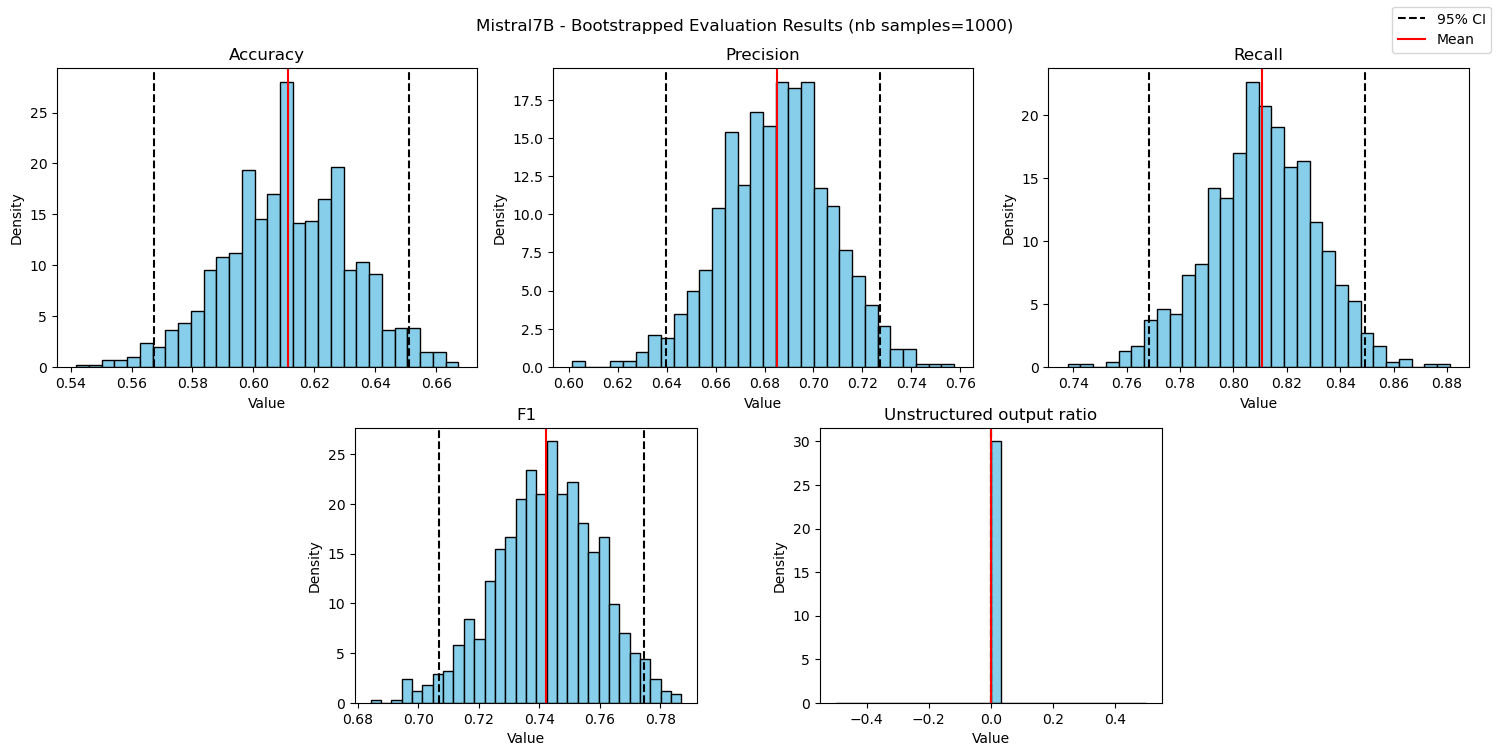

In [7]:
scorer_mistral7b = scorer_factory(scorer_type="binary", data=data, results=results_mistral7b, model_name="Mistral7B")
scorer_mistral7b.display_bootstrap_results(sample_size=len(data), output_type="both", n_samples=1000)

Bootstrapping Mixtral8x7B: 100%|██████████| 1000/1000 [00:04<00:00, 223.90it/s]


accuracy: 0.6377 (0.5982-0.6818 95% CI)
precision: 0.7464 (0.7021-0.7898 95% CI)
recall: 0.7206 (0.6719-0.7678 95% CI)
f1: 0.733 (0.6967-0.7714 95% CI)
Unstructured output ratio: 0.0 (0.0-0.0 95% CI)


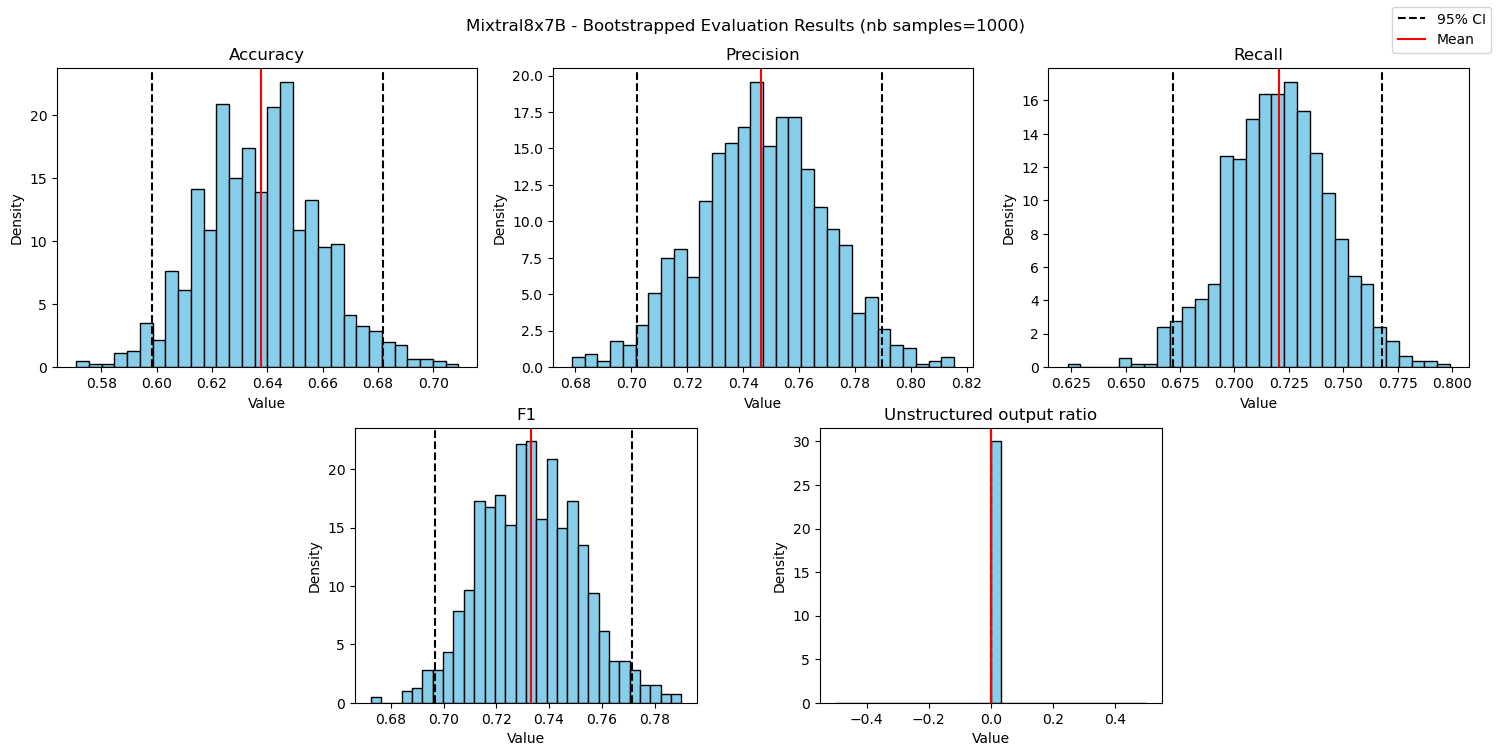

In [8]:
scorer_mixtral8x7b = scorer_factory(scorer_type="binary", data=data, results=results_mixtral8x7b, model_name="Mixtral8x7B")
scorer_mixtral8x7b.display_bootstrap_results(sample_size=len(data), output_type="both", n_samples=1000)

Bootstrapping Mistral7B:   0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrapping Mixtral8x7B: 100%|██████████| 1000/1000 [00:04<00:00, 218.35it/s]


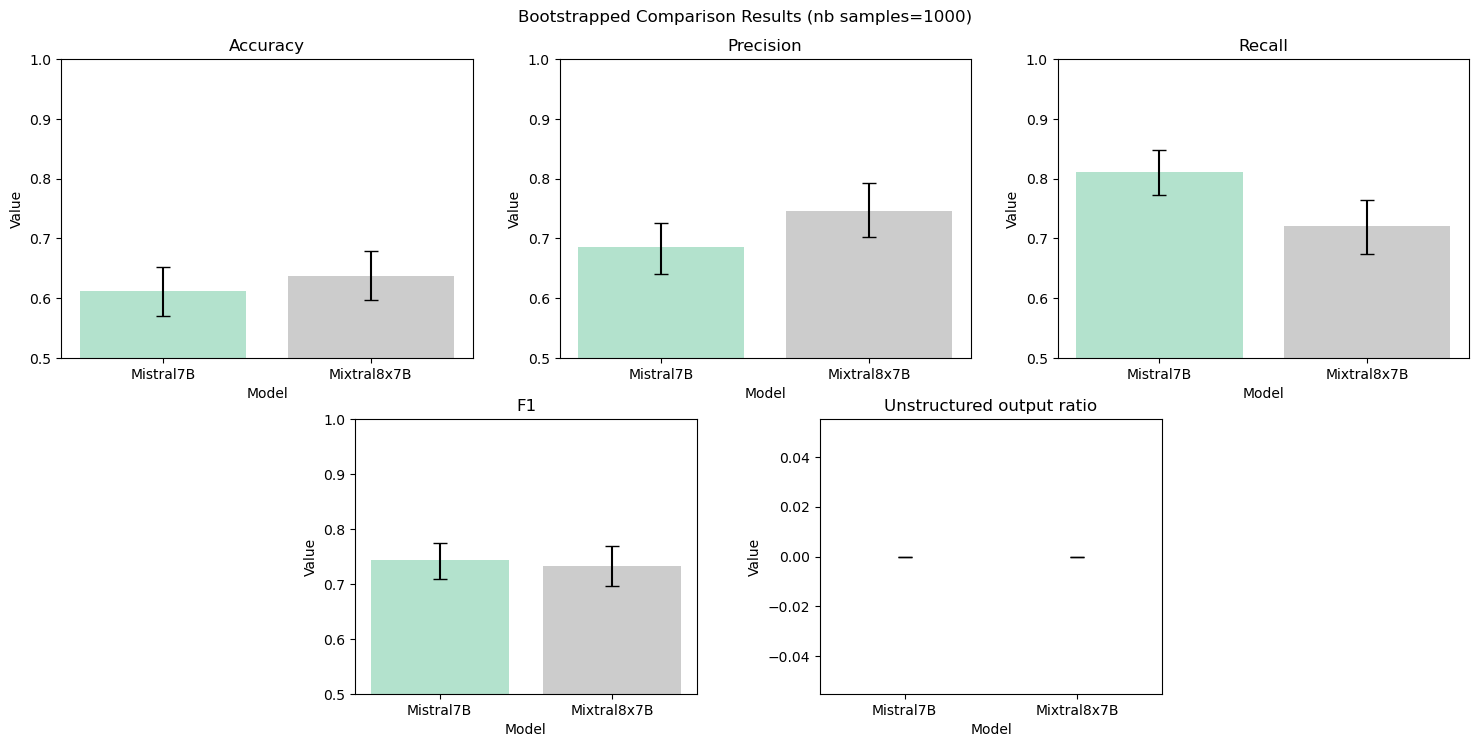

In [9]:
dict_scorers = {"Mistral7B": scorer_mistral7b, "Mixtral8x7B": scorer_mixtral8x7b}
compare_models_bootstrap(dict_scorers=dict_scorers, sample_size=len(data), n_samples=1000)

## Error Interrogation

In [10]:
df_mistral7b_error = scorer_mistral7b.get_error_dataframe()
df_mistral8x7b_error = scorer_mixtral8x7b.get_error_dataframe()

In [11]:
selected_columns = df_mistral7b_error.columns[:df_mistral7b_error.columns.get_loc("Target binary")+2].to_list() + ["Pred status"]
df_mistral7b_error[selected_columns].describe()

,Context,Symptom Status_bd,Detailed Choices_bd,Source_x,Symptom Status_CVD,Detailed Choices_CVD,Source_y,Differences,Adjudication Decision,Pres_Abs_Diffs,Target binary,symptom_detail_gs,Pred status
count,214,102,38,214,214,77,214,28,28,11,214,72,214
unique,214,2,29,50,2,51,50,13,17,2,2,53,2
top,D: OK. Have you had any any headaches?\n\nP: U...,Negative,Other,MSK0019.txt,Negative,Other,MSK0019.txt,None;Other,NONE,Negative;Positive,False,other,True
freq,1,65,5,8,137,18,8,8,10,7,142,11,142


In [19]:
df_mistral7b_error.loc[:, "Concatenated"] = df_mistral7b_error.apply(
    lambda row: f"index: {row.name}\n\nContext: {row['Context']}\n\n\nModel Prediction: {row['Pred status']}",
    axis=1
)
# Converting to a list makes for an easier way to print the results
contexts_mistral7b = df_mistral7b_error["Concatenated"].to_list()

In [69]:
random.shuffle(contexts_mistral7b)
print(contexts_mistral7b[0])

index: 406

Context: D: OK, have you had a runny nose or felt congested?

P: No. 

D: OK, um and how about any eye symptoms like redness or itchiness, pain?

P: Uh, no, nothing like that. 

D: OK. Uhm and um have you had any uh instances of fainting or feeling dizzy?

P: Nope. 

D: Any abdominal pain?

P: No.

D: Any nausea or vomiting?

P: No.

D: Any diarrhea?

P: No.

D: OK, any rashes? 

P: No rashes.

D: Um and then any muscle aches or body pains?

P: No, not that I know of.

D: OK, and how has your energy been? Have you had any fatigue or malaise the last several days?


Model Prediction: False


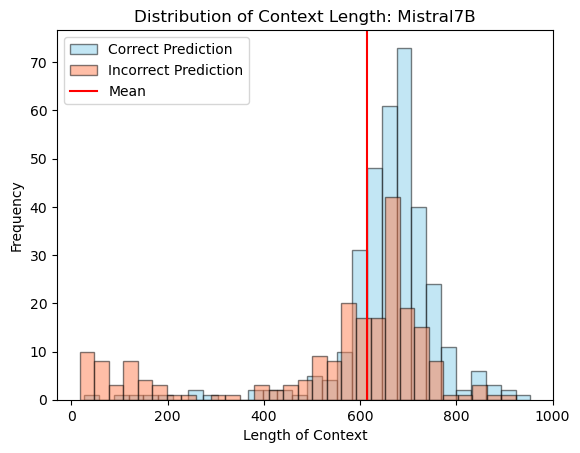

In [14]:
scorer_mistral7b.display_length_distribution()

In [15]:
selected_columns = df_mistral8x7b_error.columns[:df_mistral8x7b_error.columns.get_loc("Target binary")+2].to_list() + ["Pred status"]
df_mistral8x7b_error[selected_columns].describe()

,Context,Symptom Status_bd,Detailed Choices_bd,Source_x,Symptom Status_CVD,Detailed Choices_CVD,Source_y,Differences,Adjudication Decision,Pres_Abs_Diffs,Target binary,symptom_detail_gs,Pred status
count,199,90,52,199,199,111,199,35,35,9,199,106,199
unique,199,2,43,49,2,72,49,16,25,2,2,73,2
top,D: OK. Have you had any any headaches?\n\nP: U...,Positive,Other,RES0009.txt,Positive,Other,RES0009.txt,None;Other,NONE,Negative;Positive,True,other,False
freq,1,51,6,10,111,18,10,8,9,6,106,11,106


In [20]:
df_mistral8x7b_error.loc[:, "Concatenated"] = df_mistral8x7b_error.apply(
    lambda row: f"index: {row.name}\n\nContext: {row['Context']}\n\n\nModel Prediction: {row['Pred status']}",
    axis=1
)
# Converting to a list makes for an easier way to print the results
contexts_mistral8x7b = df_mistral8x7b_error["Concatenated"].to_list()

In [17]:
random.shuffle(contexts_mistral8x7b)
print(contexts_mistral8x7b[0])

index: 289

Context: D: And any kind of numbness or loss of sensation in your buttocks area or just below your lower back?

P: Um no

D: OK. And any fevers or chills?

P: Nope.

D: Any night sweats?

P: No.

D: Any um skin changes or rashes?

P: No.

D: Any, have you been ill recently at all with cough cold symptoms at all?

P: No.

D: Do you feel pain in anywhere else, in any other muscles or joints at all?

P: Um no.

D: Have you recently had any changes to your weight?

P: No.

D: OK. And. Any kind of changes to your bowel movements? 

P: No.

D: OK. Any kind of issues with urination at all?

P: No.


Model Prediction: False


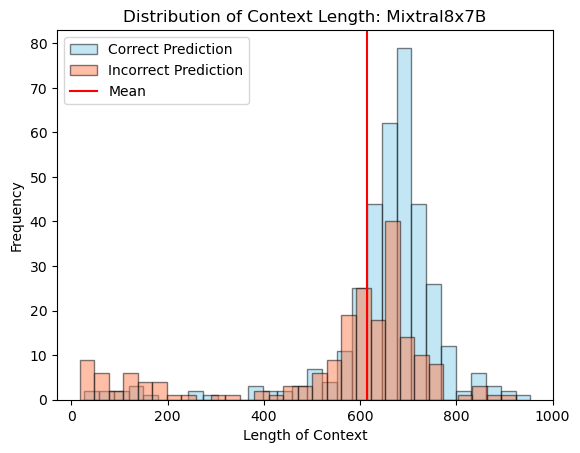

In [18]:
scorer_mixtral8x7b.display_length_distribution()